## load dependency and args

In [1]:
#!/usr/bin/env python
import argparse
import builtins
import os
import shutil
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torchvision.models as models

import sys
sys.path.extend(['..', '.'])
from datasets.dataset_tinyimagenet import load_train, load_val_loader, num_classes_dict
from tools.store import ExperimentLogWriter
import models.builder as model_builder
import utils

from sklearn.cluster import KMeans
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))
model_names += ['resnet18_cifar_variant1']

args = argparse.Namespace(
    dataset='cifar10',
    arch='resnet18_cifar_variant1',
    workers=1,
    epochs=100,
    start_epoch=0,
    batch_size=256,
    lr=30.0,
    schedule=[60, 80],
    momentum=0.9,
    weight_decay=0.0,
    print_freq=10,
    evaluate=False,
    world_size=-1,
    rank=-1,
    dist_url='tcp://224.66.41.62:23456',
    dist_backend='nccl',
    seed=None,
    gpu=None,
    multiprocessing_distributed=False,
    opt='sgd',
    dir='log/spectral/completed-2023-05-13spectral-resnet18-mlp1000-norelu-cifar10-lr003-mu1-log_freq:20',
    num_per_class=int(1e10),
    val_every=5,
    latest_only=True,
    mpd=False,
    dist_url_add=0,
    specific_ckpts=None,
    use_random_labels=False,
    normalize=False,
    nomlp=True,
    aug='standard',
    download=True
)


Jump to **Without retraining..** if we want to load pretrained embedding

## Generate embeddings from model and dataloader
### For Cifar10's train loader, the return shape will be (50000, 512), where 512 is embedding dimension

In [2]:
def get_embeddings(model, dataloader, device):

    # Copy the model
    embedding_model = model
    embedding_model = embedding_model.to(device)

    # Set the model in evaluation mode
    embedding_model.eval()

    # Initialize an empty tensor to store all the embeddings
    all_embeddings = torch.empty((0, 10)).to(device)
    
    with torch.no_grad():
        for i, (images, _) in enumerate(dataloader):
            print(i)
            images = images.to(device)
            
            # Get embeddings for this batch and flatten them
            embeddings = embedding_model(images).view(images.size(0), -1)

            # Concatenate with the previous embeddings
            all_embeddings = torch.cat((all_embeddings, embeddings))

    return all_embeddings


In [3]:
def print_model_layers(model):
    print(model)


# model = model_builder.get_model(num_classes_dict[args.dataset], arch=args.arch)

# print_model_layers(model)


## extract_embedding load pretrained model (spectral model) and returned the embedding 

In [4]:
def extract_embedding(args):
    # loop through checkpoints and set pre-trained
    ckpt_dir = os.path.join(args.dir, 'checkpoints')
    for fname in sorted(os.listdir(ckpt_dir)):
        if args.latest_only and not fname.startswith('latest_'): continue
        if args.specific_ckpts is not None and fname not in args.specific_ckpts: continue
        args.pretrained = os.path.join(ckpt_dir, fname)
    args.distributed = False
    
    model = model_builder.get_model(num_classes_dict[args.dataset], arch=args.arch)
    # load from pre-trained, before DistributedDataParallel constructor
    if args.pretrained:
        if os.path.isfile(args.pretrained):
            checkpoint = torch.load(args.pretrained, map_location='cpu')
            state_dict = checkpoint['state_dict']
            model_builder.load_checkpoint(model, state_dict, args.pretrained, args=args, nomlp=args.nomlp)
        else:
            print("=> no checkpoint found at '{}'".format(args.pretrained))
    
    random_labels = None
    train_sampler, train_loader = load_train(args.dataset, args.num_per_class, args.distributed,
                                             args.batch_size, args.workers, data_aug=args.aug, random_labels=random_labels)
    
    embeddings = get_embeddings(model, train_loader, args.gpu)
    
    print(f"Embeddings shape: {embeddings.shape}")  # Should be [50000, 10]
    
    return embeddings

## Calcuate embedding and save

In [5]:
# Calculate embeddings
embeddings = extract_embedding(args)

=> loading checkpoint 'log/spectral/completed-2023-05-13spectral-resnet18-mlp1000-norelu-cifar10-lr003-mu1-log_freq:20/checkpoints/latest_800.pth'
=> loaded pre-trained model 'log/spectral/completed-2023-05-13spectral-resnet18-mlp1000-norelu-cifar10-lr003-mu1-log_freq:20/checkpoints/latest_800.pth'
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
Embeddings shape: torch.Si

In [6]:
assert(embeddings.shape == (50000, 10))

In [7]:
# Create the "data" folder if it doesn't exist
if not os.path.exists("data"):
    os.makedirs("data")

# Save the embeddings tensor to a file in the "data" folder
file_path = "data/embeddings_10.pt"
torch.save(embeddings, file_path)

print("Embeddings saved successfully.")


Embeddings saved successfully.


## Without retraining, load calculated embedding

In [8]:
# Check if the file exists
file_path = "data/embeddings_10.pt"
if not os.path.exists(file_path):
    print("Embeddings file not found.")
else:
    # Load the embeddings tensor from the file
    embeddings = torch.load(file_path)

    # Print the shape or any other desired information about the loaded embeddings
    print("Loaded embeddings shape:", embeddings.shape)

Loaded embeddings shape: torch.Size([50000, 10])


## Define functions for flipping experiment
### 1. flip a certain number of data points in the train set
### 2. generate embeddings for all points in train set
### 3. perform K-means into 2r clusters (r is the number of classes)
### 4. use marjority vote in each clusters to determine mislabels

In [9]:
def flip_labels(labels, flip_ratio, num_classes):
    # We flip labels randomly based on the given ratio
    total_labels = len(labels)
    num_flip = int(total_labels * flip_ratio)

    flip_indices = np.random.choice(total_labels, num_flip, replace=False)
    original_labels = labels.copy()

    for idx in flip_indices:
        labels[idx] = (labels[idx] + np.random.randint(1, num_classes)) % num_classes

    return labels, flip_indices, original_labels

def get_majority_vote_label(labels):
    label_counts = Counter(labels)
    return label_counts.most_common(1)[0][0]

def calculate_accuracy(predicted_labels, actual_labels):
    correct_predictions = (np.array(predicted_labels) == np.array(actual_labels)).sum()
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy

In [10]:
def load_labels(train_loader):
    labels = []
    for _, label in train_loader:
        labels.extend(label.tolist())
    return labels

In [11]:
# Load and build the model
# loop through checkpoints and set pre-trained
ckpt_dir = os.path.join(args.dir, 'checkpoints')
for fname in sorted(os.listdir(ckpt_dir)):
    if args.latest_only and not fname.startswith('latest_'): continue
    if args.specific_ckpts is not None and fname not in args.specific_ckpts: continue
    args.pretrained = os.path.join(ckpt_dir, fname)
args.distributed = False

model = model_builder.get_model(num_classes_dict[args.dataset], arch=args.arch)
# load from pre-trained, before DistributedDataParallel constructor
if args.pretrained:
    if os.path.isfile(args.pretrained):
        checkpoint = torch.load(args.pretrained, map_location='cpu')
        state_dict = checkpoint['state_dict']
        model_builder.load_checkpoint(model, state_dict, args.pretrained, args=args, nomlp=args.nomlp)
    else:
        print("=> no checkpoint found at '{}'".format(args.pretrained))

=> loading checkpoint 'log/spectral/completed-2023-05-13spectral-resnet18-mlp1000-norelu-cifar10-lr003-mu1-log_freq:20/checkpoints/latest_800.pth'
=> loaded pre-trained model 'log/spectral/completed-2023-05-13spectral-resnet18-mlp1000-norelu-cifar10-lr003-mu1-log_freq:20/checkpoints/latest_800.pth'


In [12]:
random_labels = None
train_sampler, train_loader = load_train(args.dataset, args.num_per_class, args.distributed,
                                         args.batch_size, args.workers, data_aug=args.aug, random_labels=random_labels)

# Load original labels
original_labels = load_labels(train_loader)
    

In [36]:
# Flip labels
labels, flip_indices, original_labels = flip_labels(original_labels, flip_ratio=0.08, num_classes=10)

In [37]:
num_different_elements = sum(1 for x, y in zip(labels, original_labels) if x != y)
print("Number of different labels:", num_different_elements)

Number of different labels: 4000


## Define the number of clusters



In [39]:
num_classes = len(set(labels)) # 10
num_clusters = num_classes*10

## Run K-means

#clusters = 100 * #classes, i.e. 1000 clusters, 50 images in each cluster in average

In [40]:
kmeans_100 = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings)

/Users/jinhuang/opt/miniconda3/envs/spectral/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


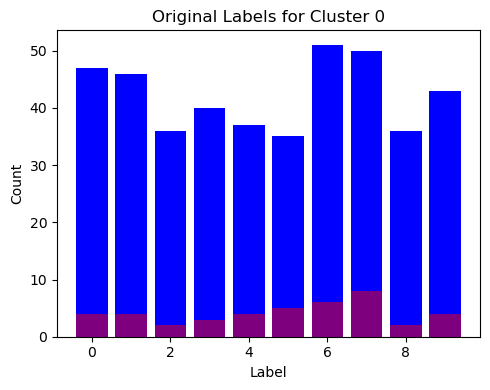

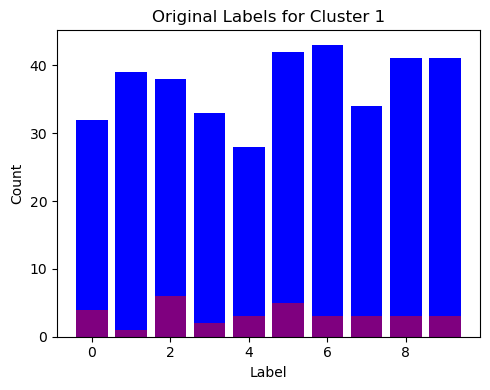

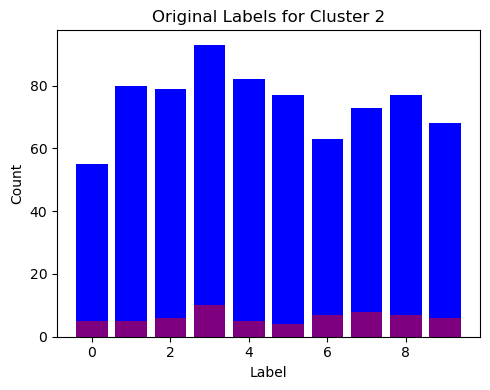

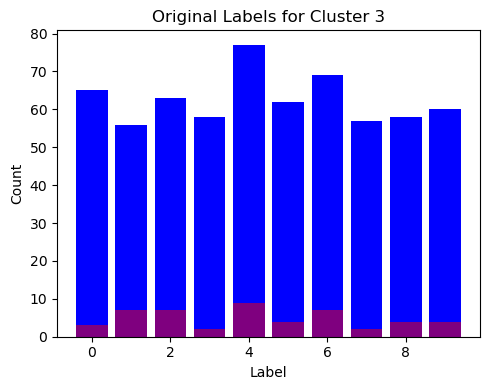

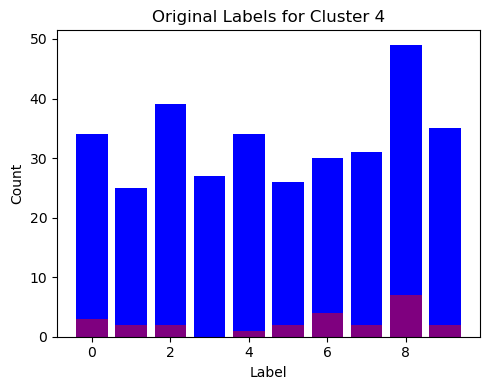

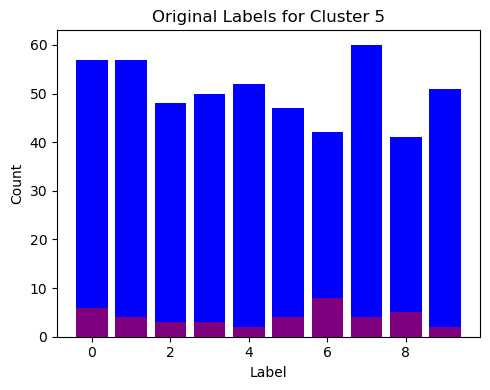

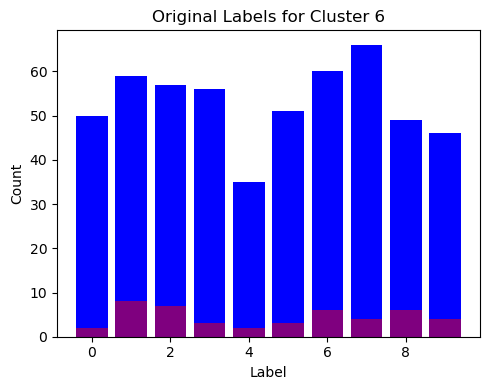

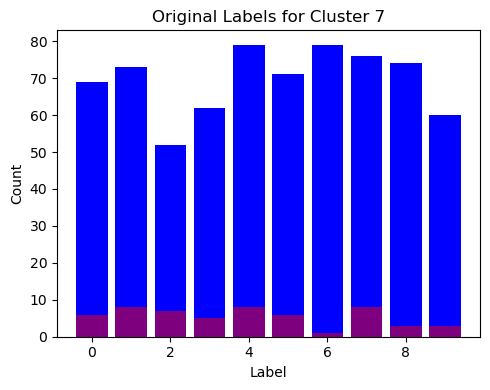

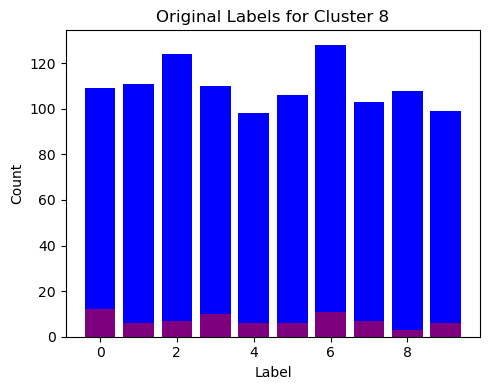

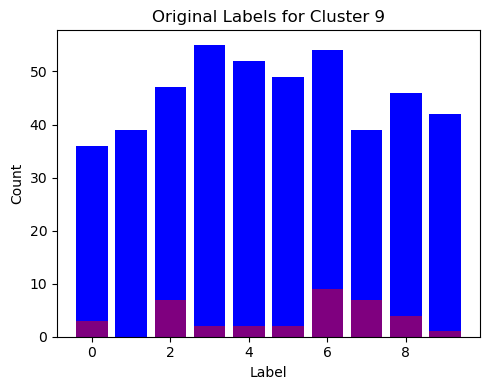

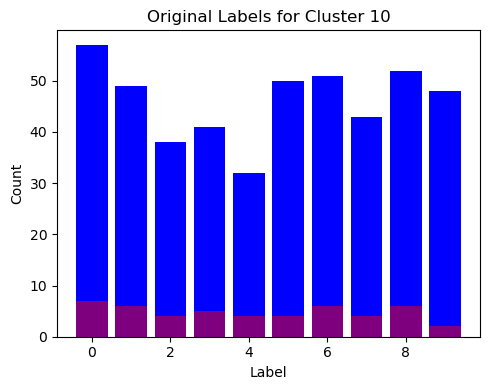

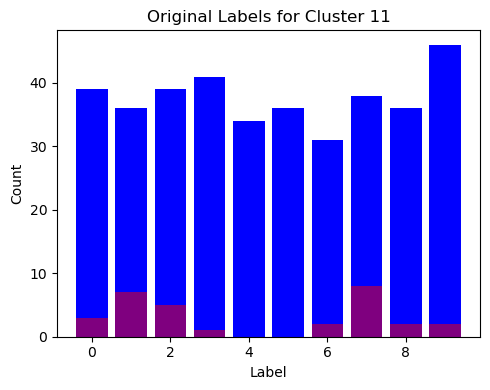

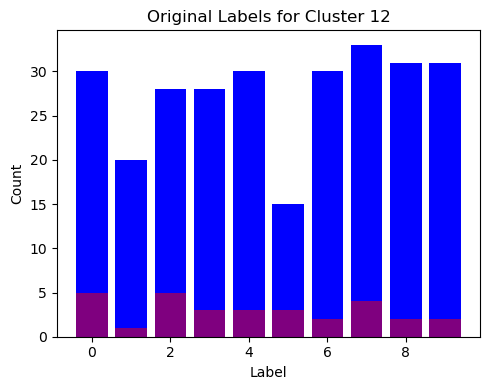

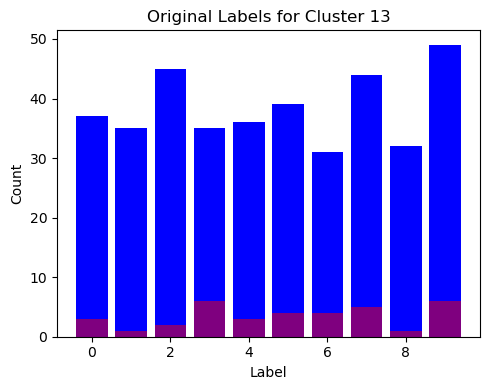

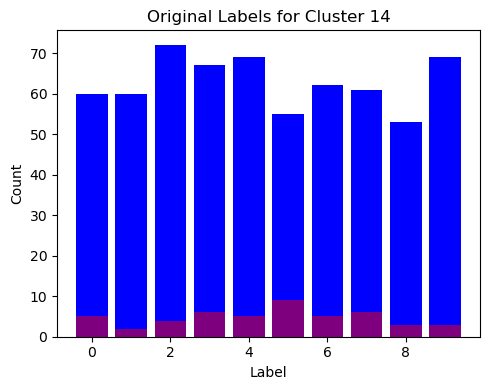

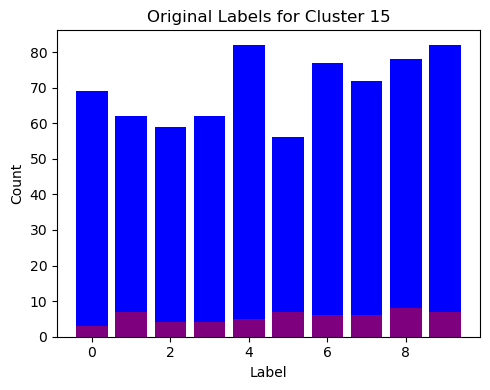

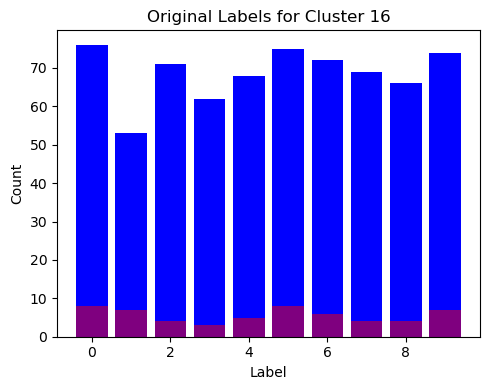

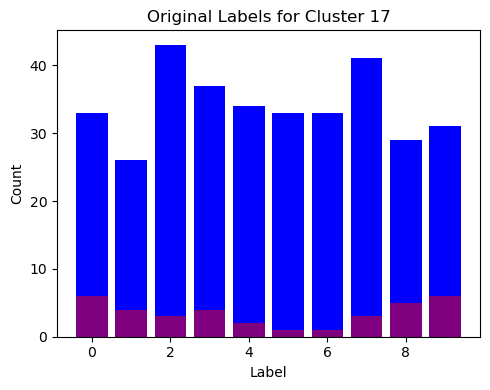

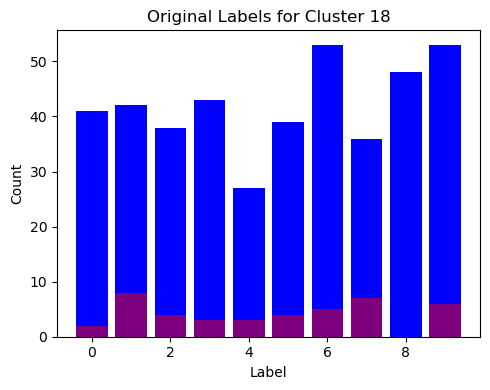

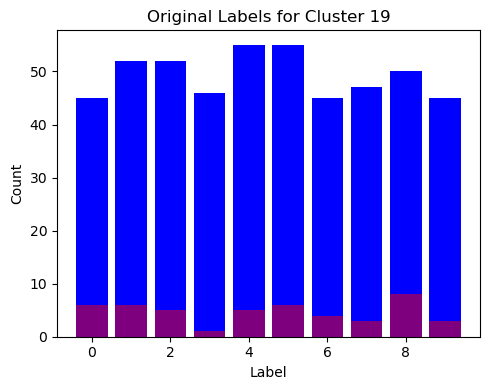

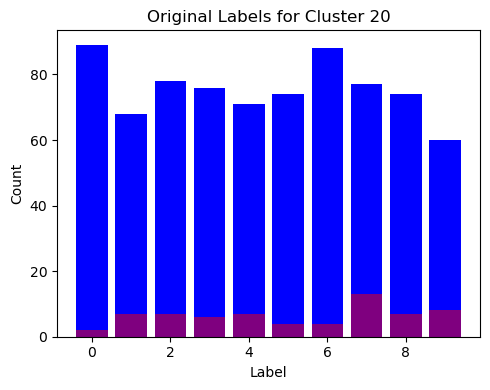

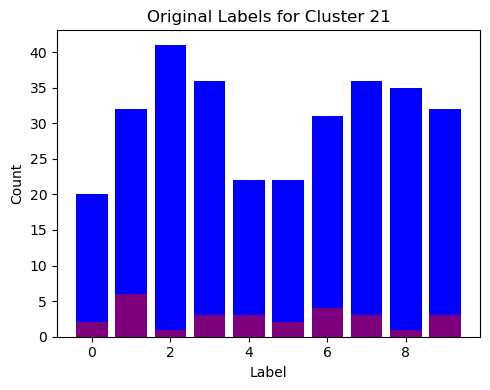

In [46]:
for cluster in range(num_clusters):
    cluster_indices = np.where(kmeans_100.labels_ == cluster)[0]
    cluster_indices = cluster_indices.astype(int)

    cluster_labels = np.array(labels)[cluster_indices]
    majority_vote_label = get_majority_vote_label(cluster_labels)

    # Get counts of original labels
    original_label_counts = Counter(np.array(labels)[cluster_indices])

    # Plot original label counts
    plt.figure(figsize=(5, 4))
    plt.bar(original_label_counts.keys(), original_label_counts.values(), color='b')
    plt.title(f'Original Labels for Cluster {cluster}')
    plt.xlabel('Label')
    plt.ylabel('Count')

    # Check if the cluster contains any mislabeled points
    mislabeled_in_cluster = set(cluster_indices) & set(flip_indices)
    if mislabeled_in_cluster:
        mislabeled_label_counts = Counter(np.array(labels)[list(mislabeled_in_cluster)])
        plt.bar(mislabeled_label_counts.keys(), mislabeled_label_counts.values(), color='r', alpha=0.5)
    plt.tight_layout()
    plt.show()

    if cluster > 20:
        break


## Visualization of clusters 

In [22]:
# Reduce dimensionality for visualization
embeddings_2d = TSNE(n_components=2).fit_transform(embeddings)

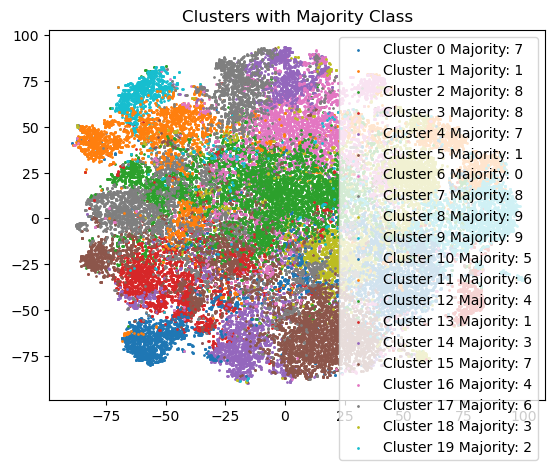

In [23]:
# Detect mislabeled data points
predicted_labels = []
for cluster in range(num_classes*2):
    cluster_indices = np.where(kmeans.labels_ == cluster)[0]
    cluster_indices = cluster_indices.astype(int)
    
    cluster_labels = np.array(labels)[cluster_indices]

    majority_vote_label = get_majority_vote_label(cluster_labels)

    predicted_labels.extend([majority_vote_label]*len(cluster_labels))

    # Plot each cluster
    plt.scatter(embeddings_2d[cluster_indices, 0], embeddings_2d[cluster_indices, 1], label=f"Cluster {cluster} Majority: {majority_vote_label}", s=1)

plt.title("Clusters with Majority Class")
plt.legend()
plt.show()

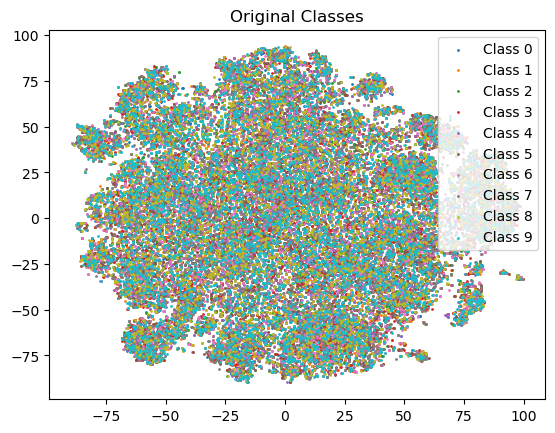

In [24]:
# Create a scatter plot with original labels
for label in set(original_labels):
    indices = np.where(np.array(original_labels) == label)[0]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=f"Class {label}", s=1)  # Set s to a smaller value, such as 10

plt.title("Original Classes")
plt.legend()
plt.show()

In [42]:
num_classes = len(set(labels)) # 10
num_clusters = num_classes*1000 # 10000

In [43]:
kmeans_10000 = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings)

/Users/jinhuang/opt/miniconda3/envs/spectral/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


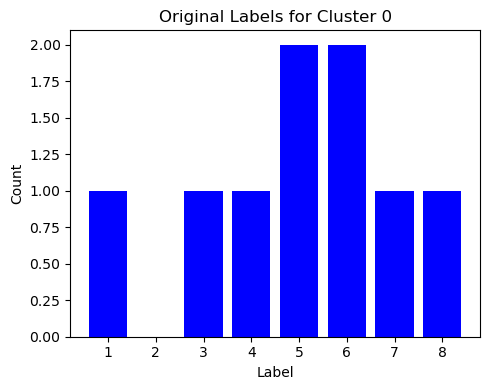

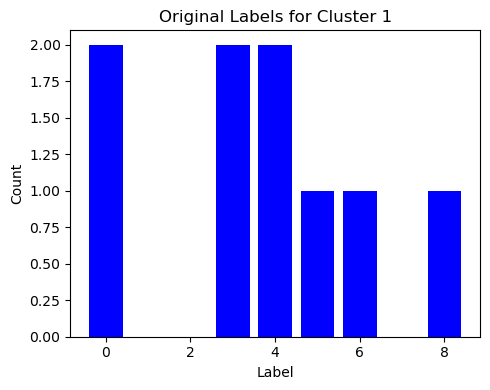

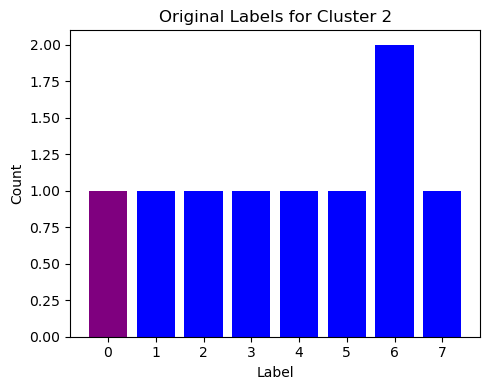

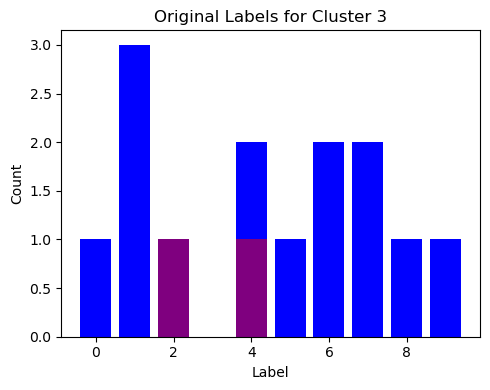

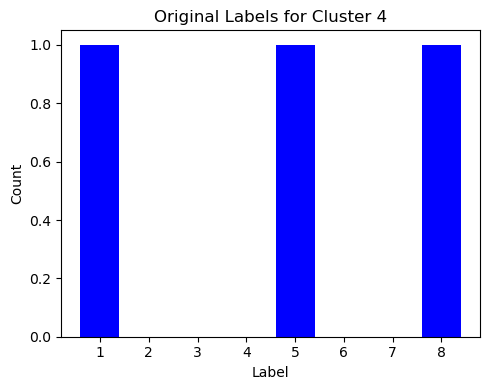

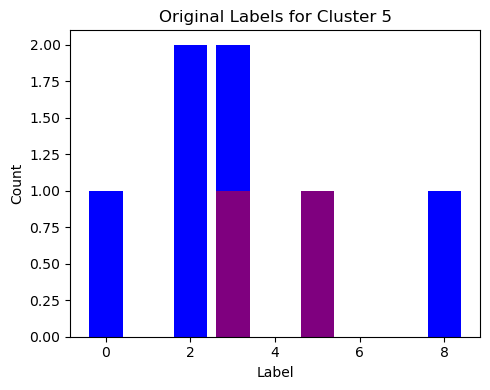

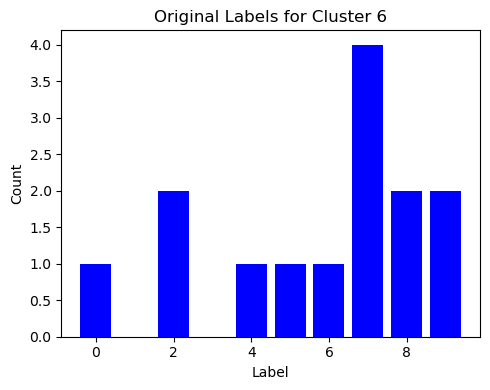

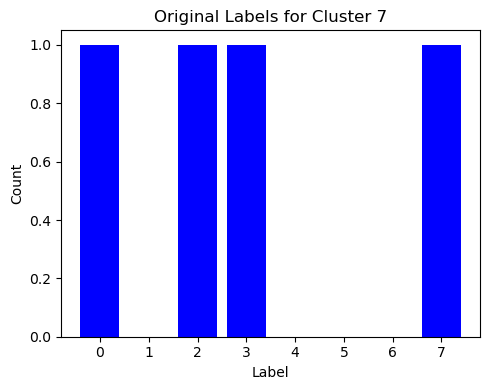

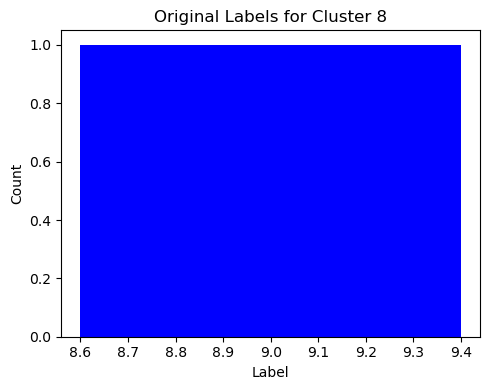

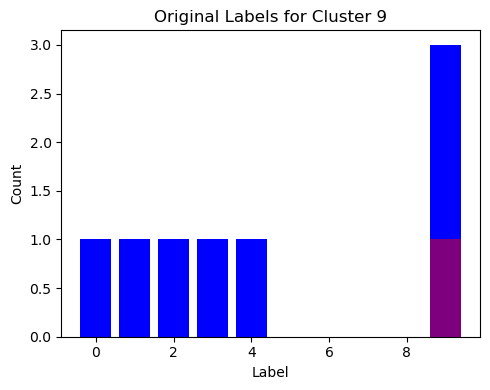

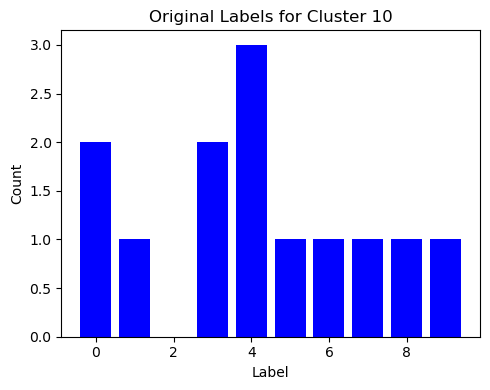

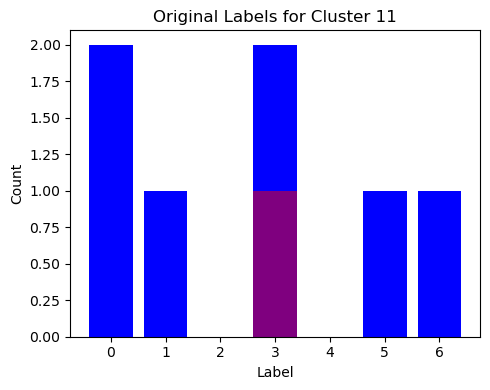

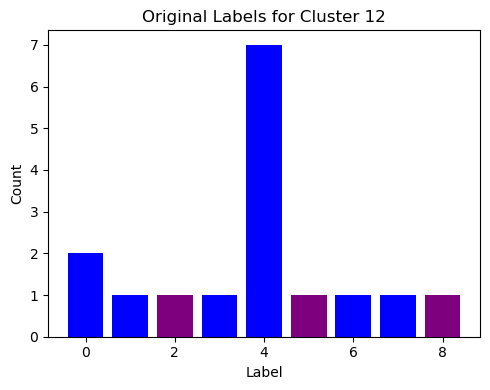

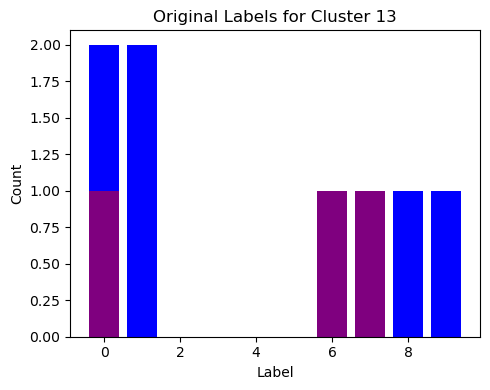

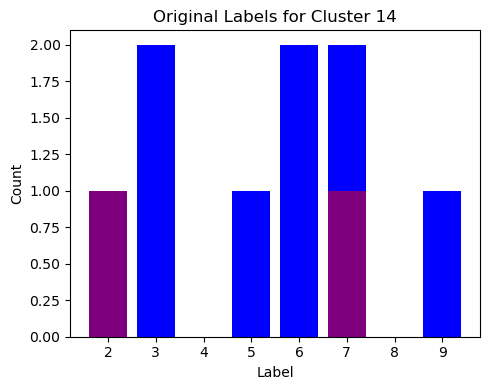

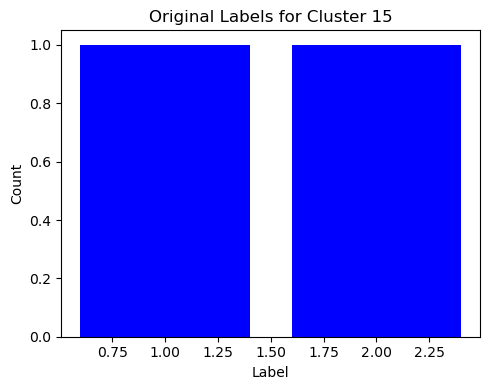

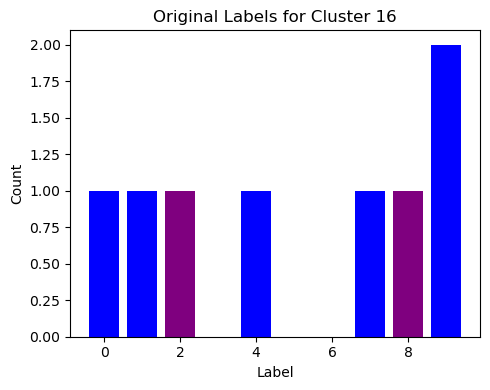

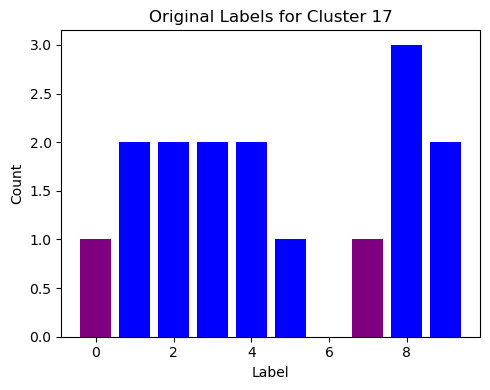

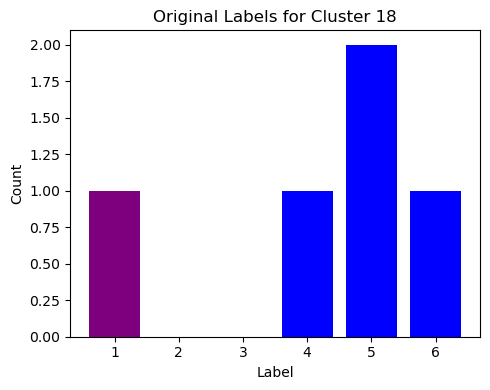

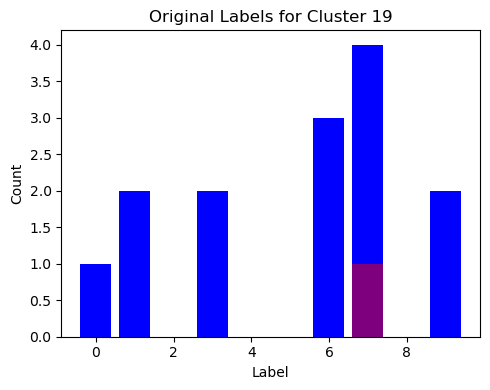

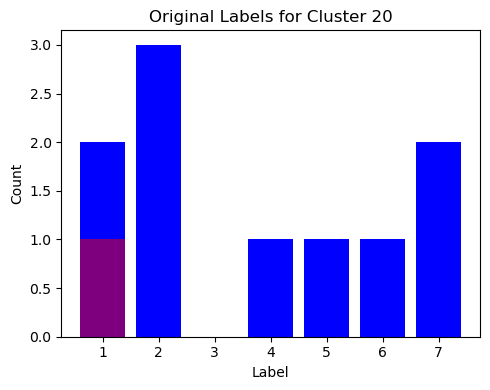

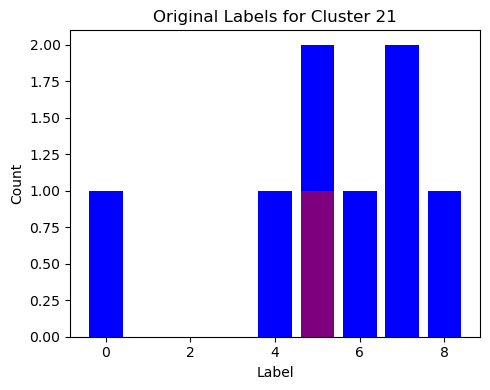

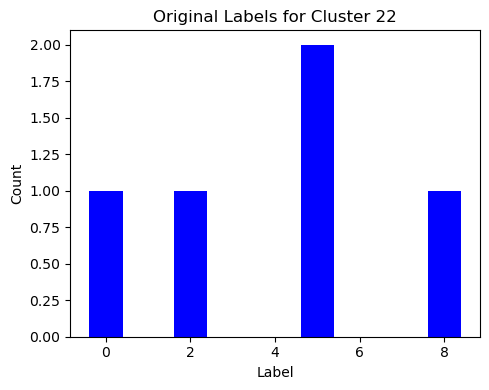

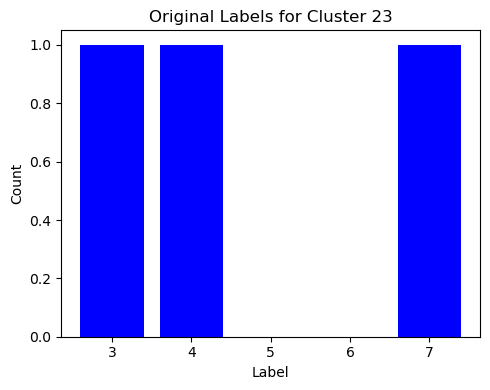

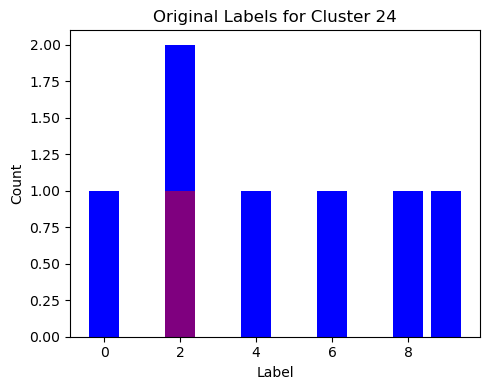

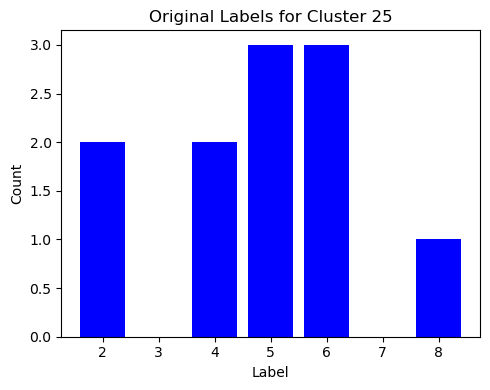

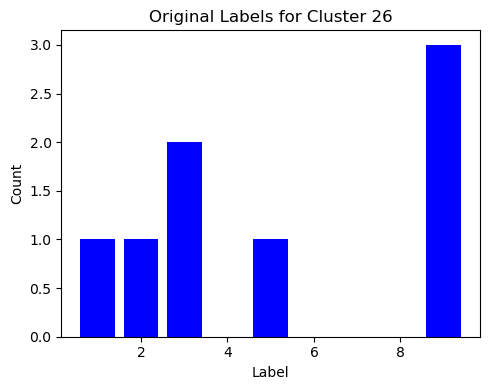

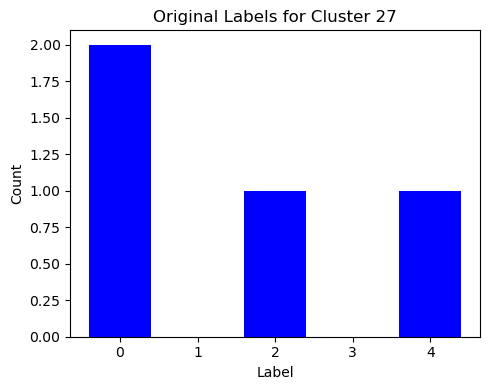

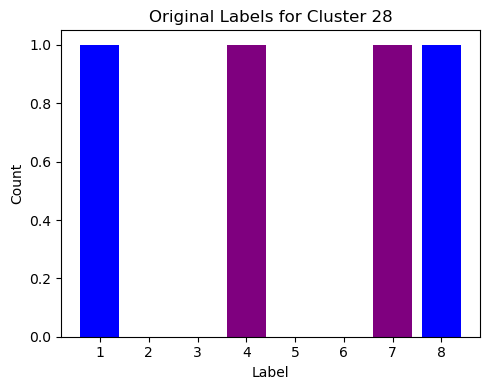

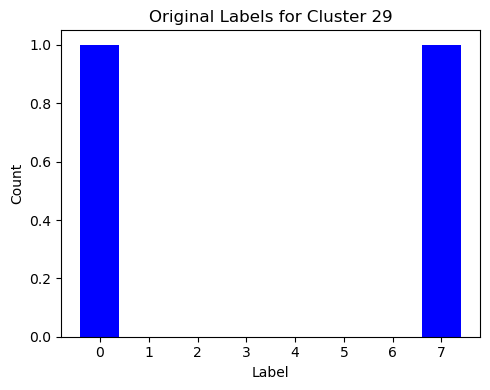

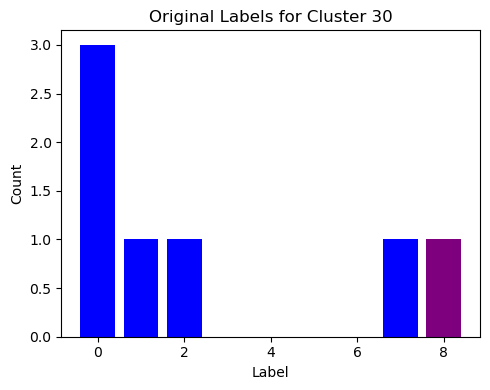

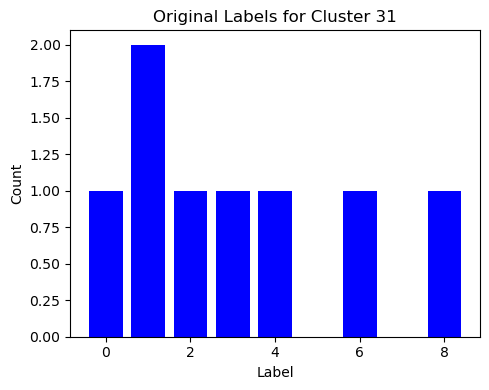

In [47]:
for cluster in range(num_clusters):
    cluster_indices = np.where(kmeans_10000.labels_ == cluster)[0]
    cluster_indices = cluster_indices.astype(int)

    cluster_labels = np.array(labels)[cluster_indices]
    majority_vote_label = get_majority_vote_label(cluster_labels)

    # Get counts of original labels
    original_label_counts = Counter(np.array(labels)[cluster_indices])

    # Plot original label counts
    plt.figure(figsize=(5, 4))
    plt.bar(original_label_counts.keys(), original_label_counts.values(), color='b')
    plt.title(f'Original Labels for Cluster {cluster}')
    plt.xlabel('Label')
    plt.ylabel('Count')

    # Check if the cluster contains any mislabeled points
    mislabeled_in_cluster = set(cluster_indices) & set(flip_indices)
    if mislabeled_in_cluster:
        mislabeled_label_counts = Counter(np.array(labels)[list(mislabeled_in_cluster)])
        plt.bar(mislabeled_label_counts.keys(), mislabeled_label_counts.values(), color='r', alpha=0.5)
    plt.tight_layout()
    plt.show()

    if cluster > 30:
        break

## Detect mislabel

In [ ]:
# Detect mislabeled data points
predicted_labels = []
for cluster in range(num_classes*2):
    cluster_indices = np.where(kmeans.labels_ == cluster)[0]
    cluster_indices = cluster_indices.astype(int)
    
#     print(f"{cluster_indices = }")
    cluster_labels = np.array(labels)[cluster_indices]

    print(f"{cluster_labels = }")

    majority_vote_label = get_majority_vote_label(cluster_labels)

    print(f"{majority_vote_label = }")

    predicted_labels.extend([majority_vote_label]*len(cluster_labels))



In [ ]:
# Calculate accuracy
print(f"{(np.array(predicted_labels) == np.array(original_labels)) = }")

accuracy = calculate_accuracy(predicted_labels, original_labels)
print(f"Accuracy: {accuracy}")

In [ ]:
def eval_ckpt_mislabeled(args, embeddings):
    # Load and build the model
    # loop through checkpoints and set pre-trained
    ckpt_dir = os.path.join(args.dir, 'checkpoints')
    for fname in sorted(os.listdir(ckpt_dir)):
        if args.latest_only and not fname.startswith('latest_'): continue
        if args.specific_ckpts is not None and fname not in args.specific_ckpts: continue
        args.pretrained = os.path.join(ckpt_dir, fname)
    args.distributed = False
    
    model = model_builder.get_model(num_classes_dict[args.dataset], arch=args.arch)
    # load from pre-trained, before DistributedDataParallel constructor
    if args.pretrained:
        if os.path.isfile(args.pretrained):
            checkpoint = torch.load(args.pretrained, map_location='cpu')
            state_dict = checkpoint['state_dict']
            model_builder.load_checkpoint(model, state_dict, args.pretrained, args=args, nomlp=args.nomlp)
        else:
            print("=> no checkpoint found at '{}'".format(args.pretrained))
    
    random_labels = None
    train_sampler, train_loader = load_train(args.dataset, args.num_per_class, args.distributed,
                                             args.batch_size, args.workers, data_aug=args.aug, random_labels=random_labels)

    # Load original labels
    original_labels = load_labels(train_loader)
    
#     print(f"{original_labels = }")
#     print(f"{original_labels.shape}")

    # Flip labels
    labels, flip_indices, original_labels = flip_labels(original_labels, flip_ratio=0.2)
    
    print(f"{(original_labels != labels).sum() = }")

   

    # Run K-means
    num_classes = len(set(labels))
    kmeans = KMeans(n_clusters=num_classes*2, random_state=0).fit(embeddings)

    # Detect mislabeled data points
    predicted_labels = []
    for cluster in range(num_classes*2):
        cluster_indices = np.where(kmeans.labels_ == cluster)[0]
        cluster_labels = labels[cluster_indices]
        
        print(f"{cluster_labels = }")
        
        majority_vote_label = get_majority_vote_label(cluster_labels)
        
        print(f"{majority_vote_label = }")
        
        predicted_labels.extend([majority_vote_label]*len(cluster_labels))

    # Calculate accuracy
    accuracy = calculate_accuracy(predicted_labels, original_labels)
    print(f"Accuracy: {accuracy}")


In [ ]:
eval_ckpt_mislabeled(args, embeddings)